# Binning with uniform kernel

In [1]:
import numpy as np
import napari
import matplotlib.pyplot as plt
from skimage.io import imread # to load images from files
from scipy.ndimage import correlate, convolve
from readPTU_FLIM import PTUreader
from FLIM_phasor import *
from napari_flim_phasor_calculator import _reader as rd
from napari_flim_phasor_calculator import phasor
from napari_flim_phasor_calculator import _plotting as phasor_plt
from napari_flim_phasor_calculator import filters

### Creating a test image array (5D)

In [2]:
image_array = np.arange(720).reshape(10, 1, 1, 12, 6) # (utime, time, z, y, x).
#print("Original Array:")
#print(image_array)

### Create function

In [3]:
def apply_conv_binning(flim_image, bin_size = 2, binning_3D=True):
    """
    docstring
    """
    image_binned = np.zeros_like(flim_image)

    if binning_3D:
        kernel=np.full((bin_size, bin_size, bin_size), 1)

        for  utime, time in np.ndindex(flim_image.shape[0], flim_image.shape[1]):
            image_binned[utime, time, :, :, :] = convolve(flim_image[utime, time, :, :, :],kernel)
    else:
        kernel=np.full((bin_size, bin_size), 1)

        for  utime, time, z in np.ndindex(flim_image.shape[0], flim_image.shape[1], flim_image.shape[2]):
            image_binned[utime, time, z, :, :] = convolve(flim_image[utime, time, z, :, :],kernel)
    
    return(image_binned)
    #try to check if it is possible to make it a one for loop as they are similar

In [4]:
image_binned = apply_conv_binning(image_array, 3)

In [5]:
viewer1 = napari.Viewer()
original_layer = viewer1.add_image(image_array)
binned_layer = viewer1.add_image(image_binned)

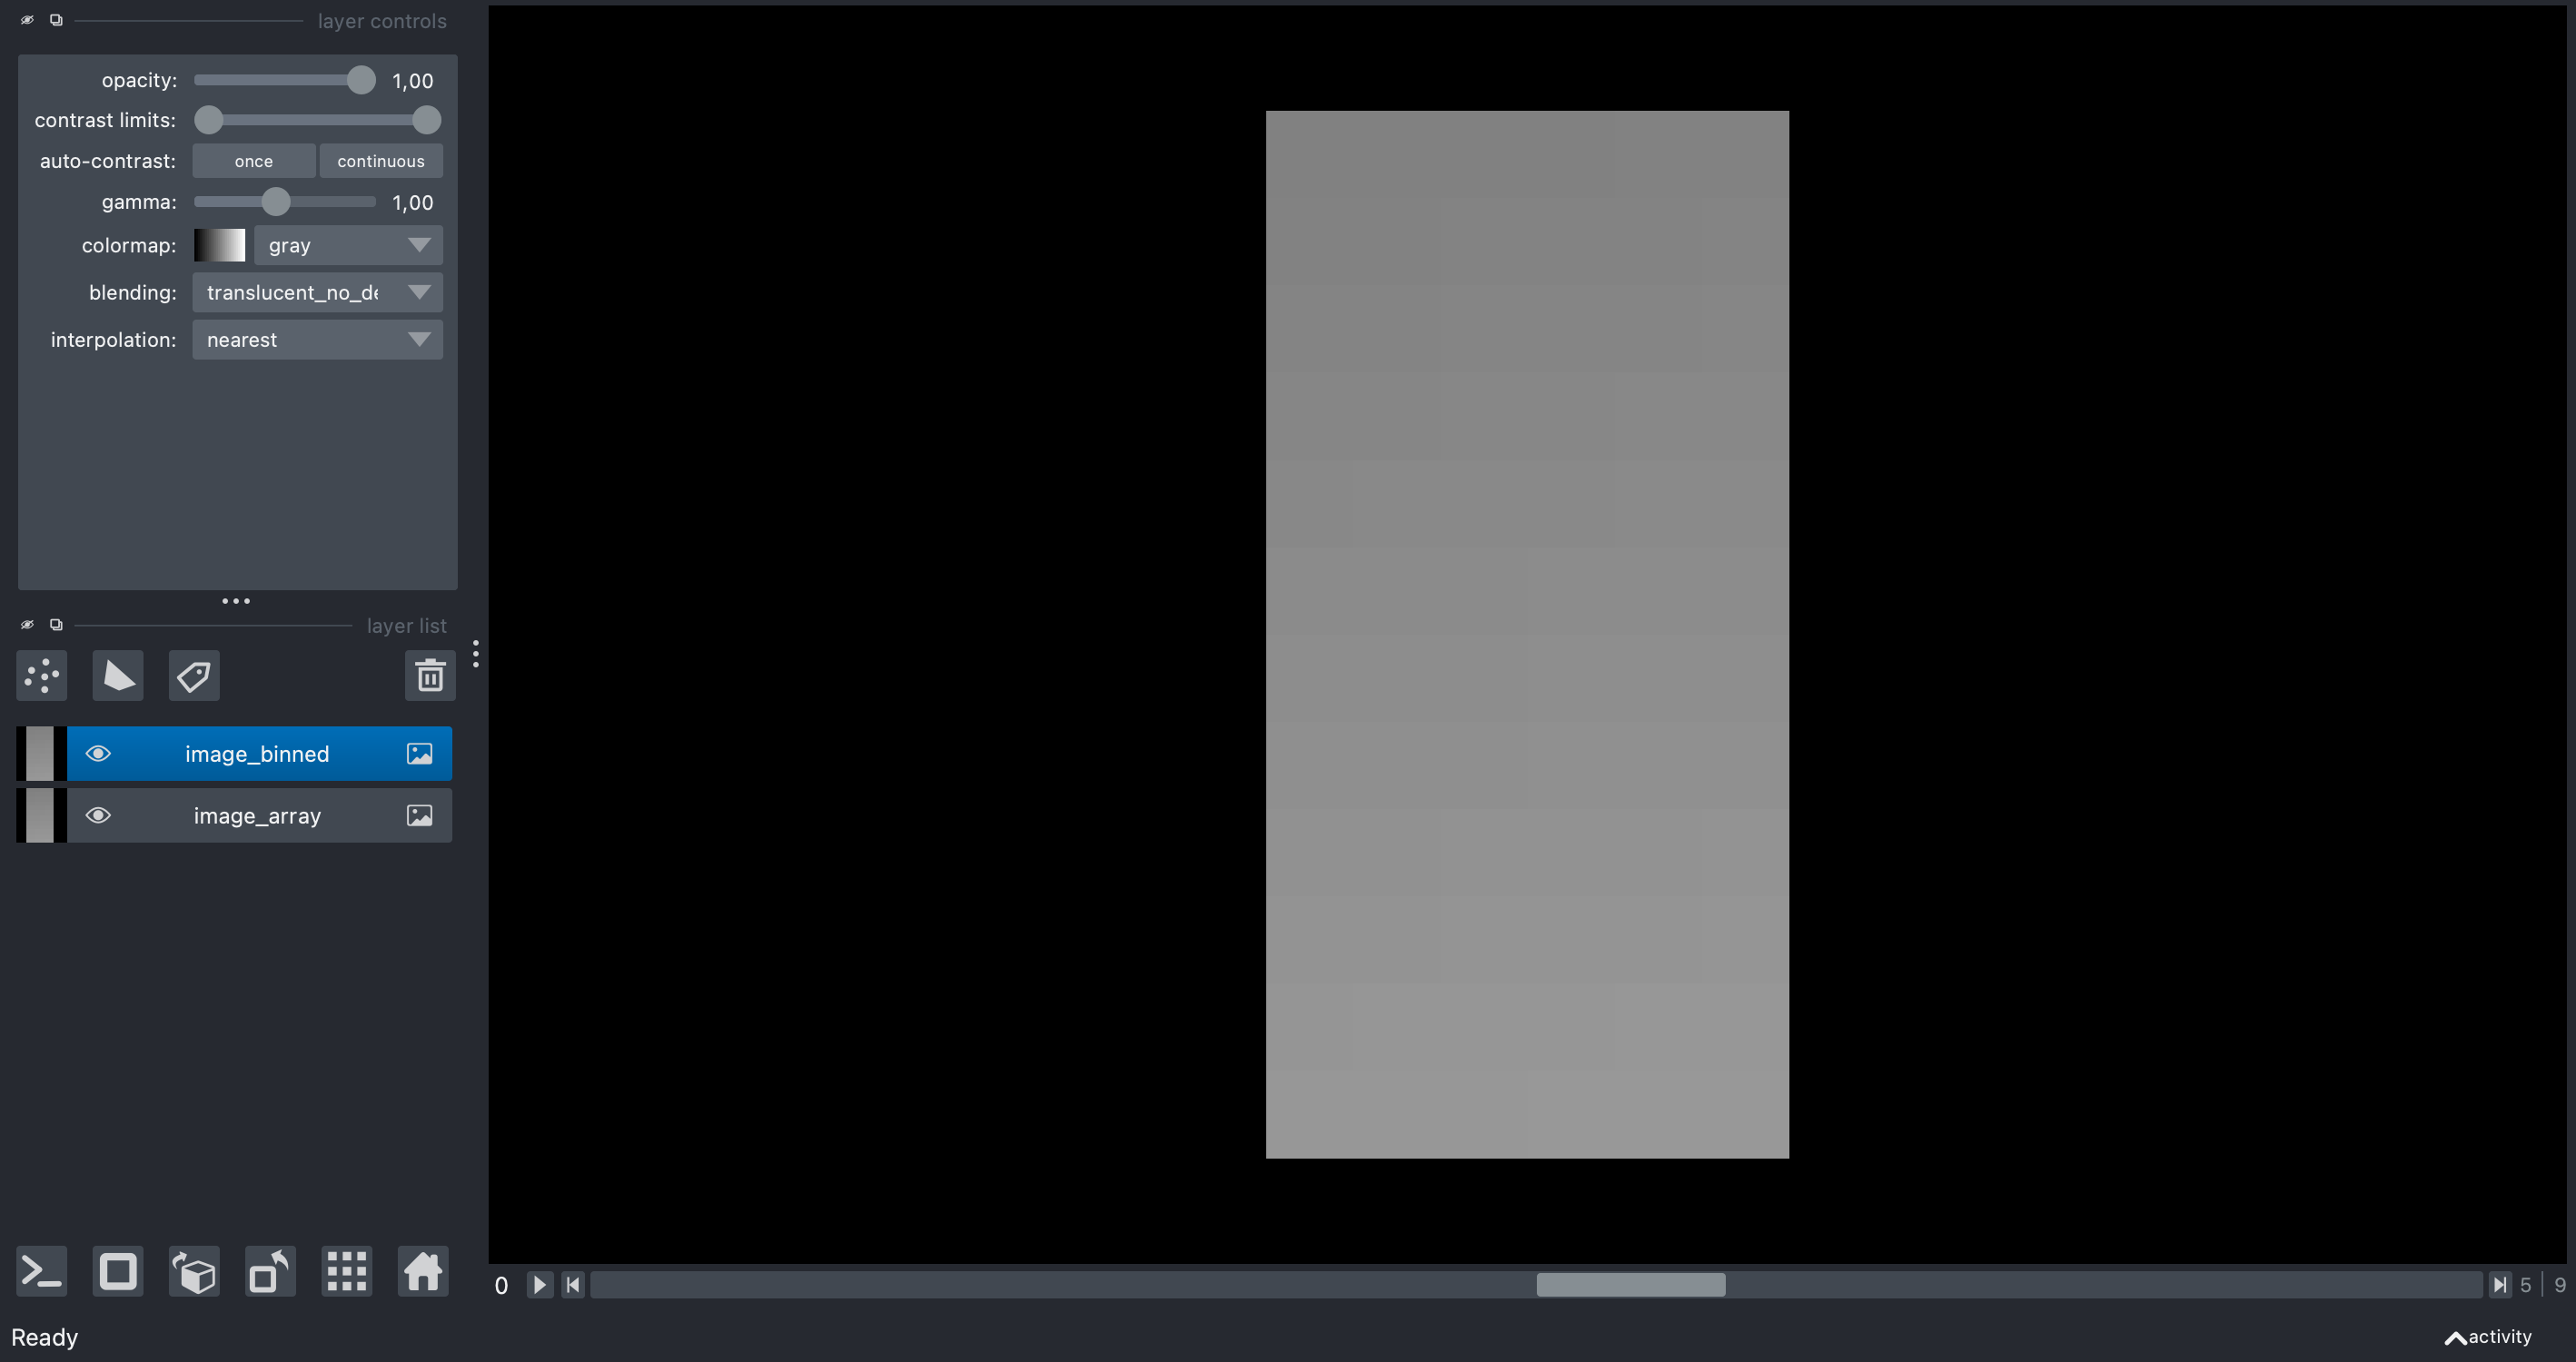

In [6]:
napari.utils.nbscreenshot(viewer1)

## Using real data

In [7]:
data_path = "/Users/lana/Documents/PoLHiWi2023/Test_data/2a_FLIM_single_image.ptu"
flim_data_file = rd.flim_file_reader(data_path)

TCSPC Hardware: PicoHarpT3
Raw Data has been Read!



In [8]:
layer = flim_data_file[0][0][0]
layer.shape

(271, 1, 1, 512, 512)

In [9]:
binned_layer = apply_conv_binning(layer, 3, binning_3D = False)

In [10]:
viewer = napari.Viewer()
viewer.add_image(layer)
viewer.add_image(binned_layer)

<Image layer 'binned_layer' at 0x7fc6dc197970>

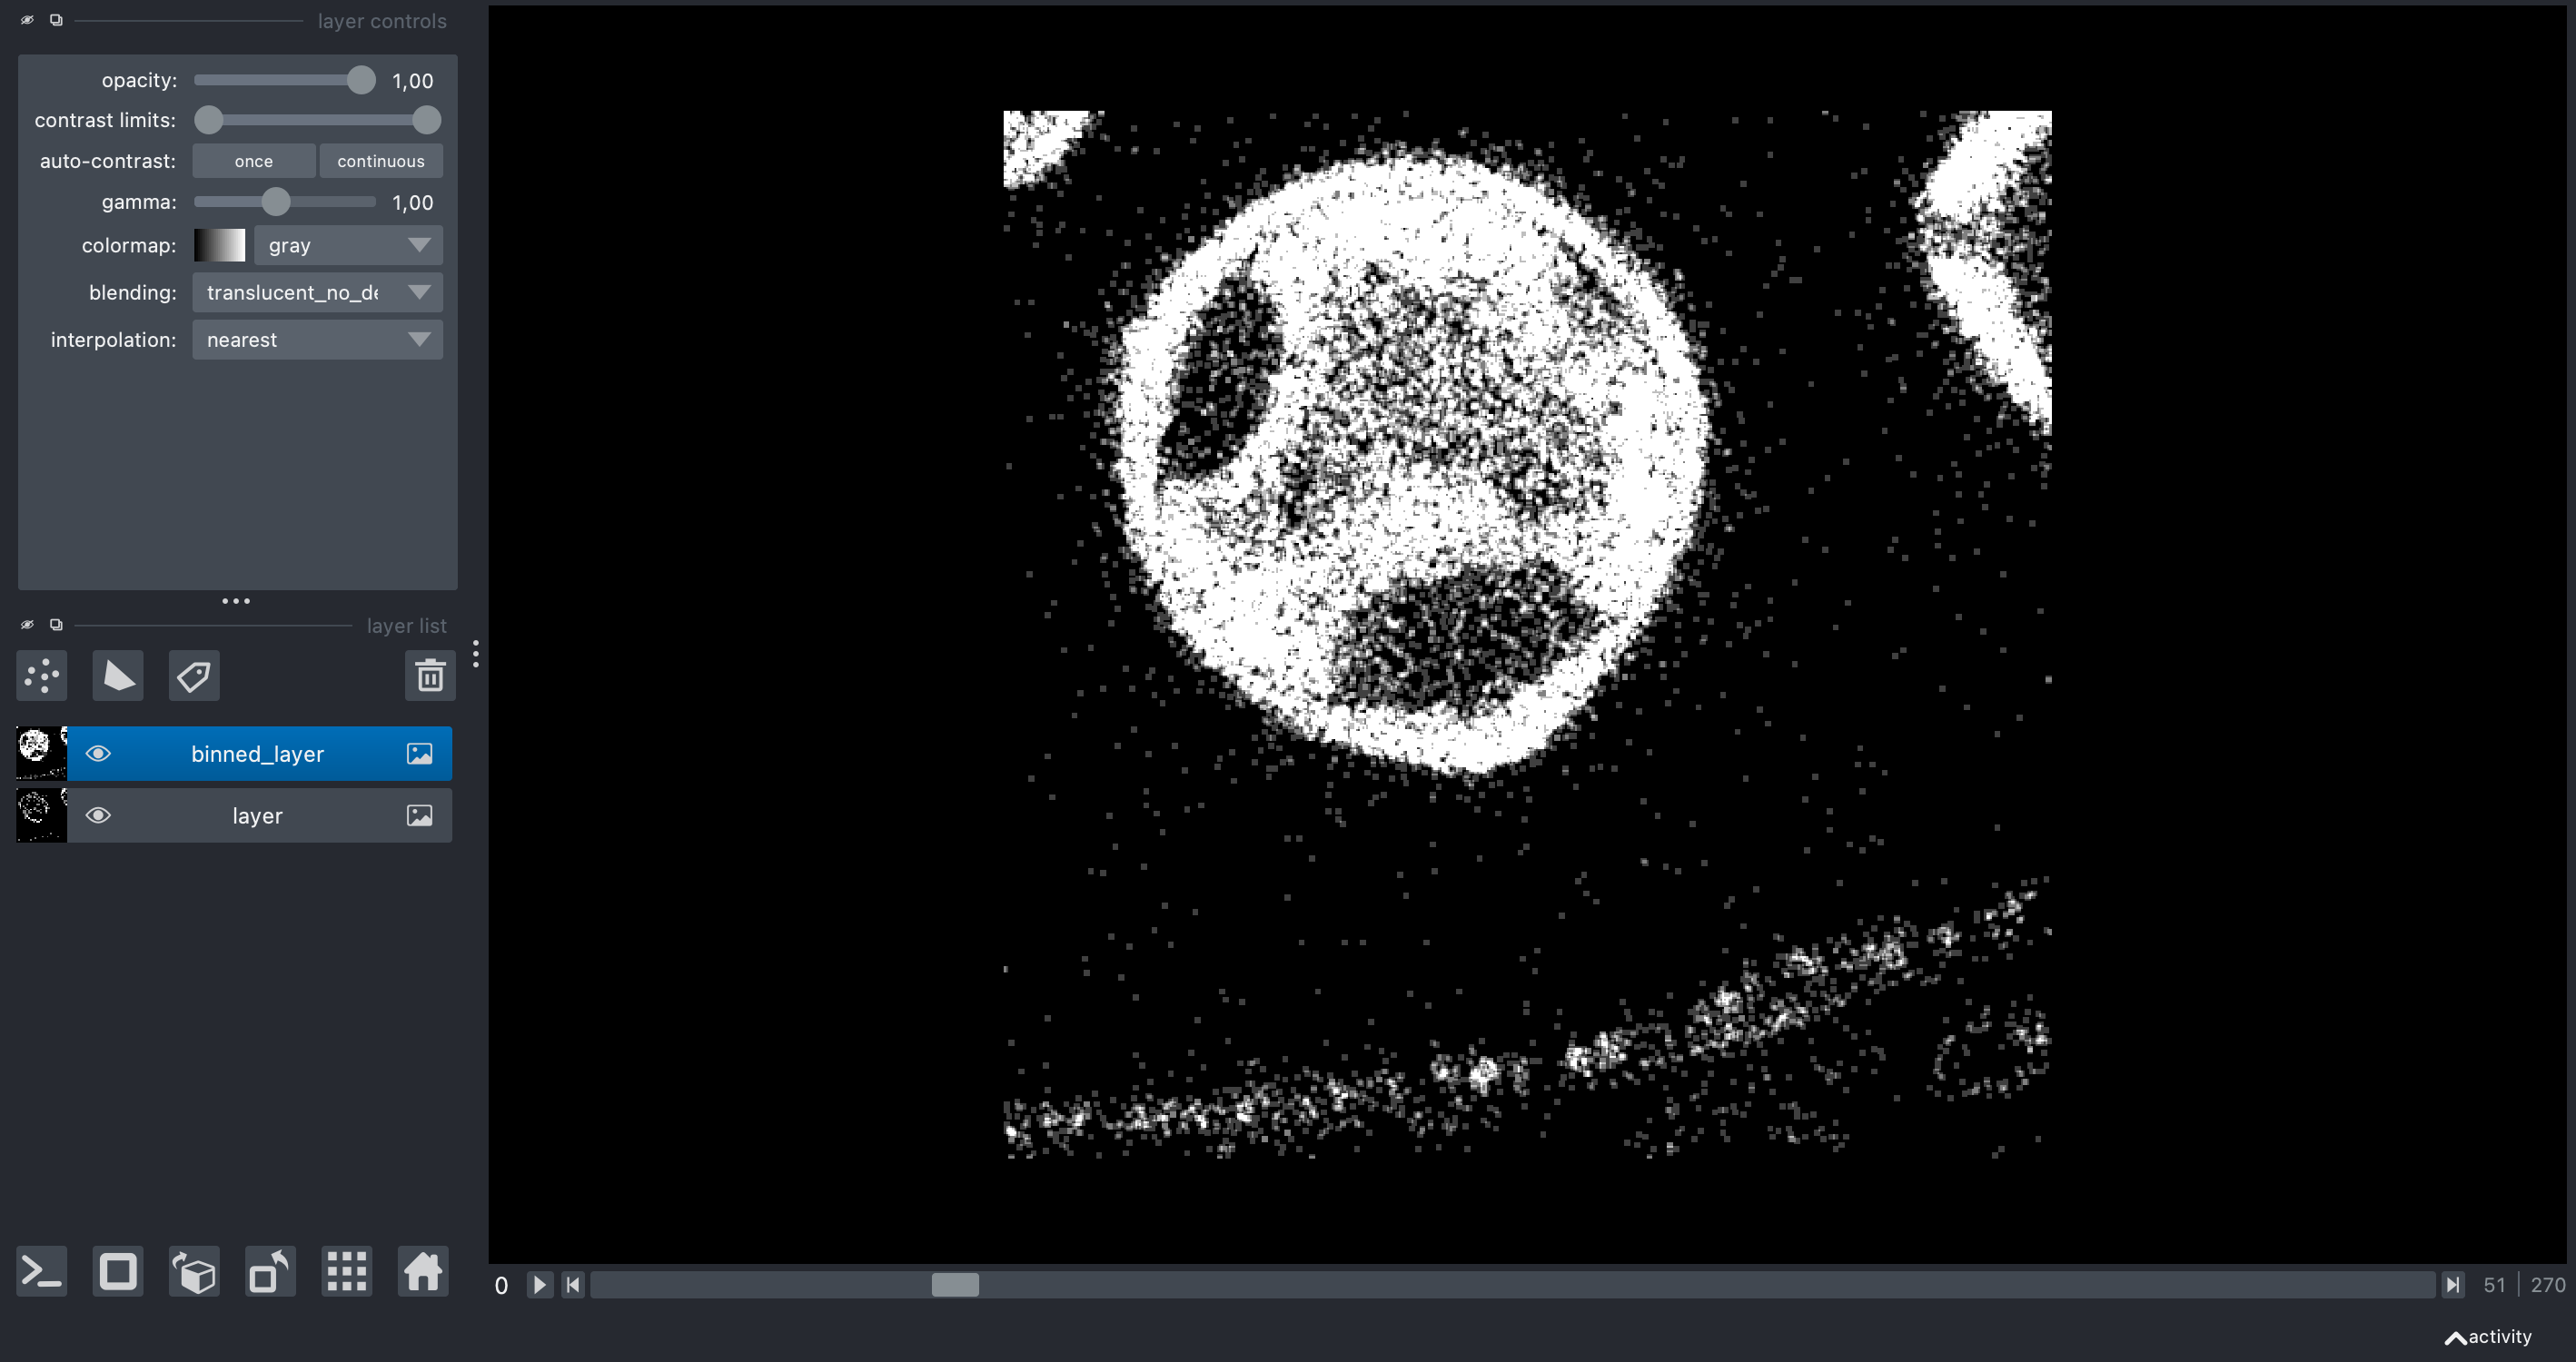

In [12]:
napari.utils.nbscreenshot(viewer)

## Comparing Phasor plots for binned and original image

In [13]:
intensity_image = flim_data_file[1][0][0]
intensity_image.shape

(1, 1, 1, 512, 512)

In [14]:
threshold = 43

space_mask = filters.make_space_mask_from_manual_threshold(layer, threshold)

In [15]:
laser_frequency = flim_data_file[0][1]['metadata'][0]['TTResult_SyncRate'] *1E-6 #MHz
laser_frequency

39.01

In [16]:
time_mask = filters.make_time_mask(layer, laser_frequency)
binned_time_mask = filters.make_time_mask(binned_layer, laser_frequency)
len(time_mask == binned_time_mask) == sum(time_mask == binned_time_mask)

True

In [17]:
number_of_harmonics = 2

In [18]:
og_phasor_comp = phasor.get_phasor_components(layer[time_mask], number_of_harmonics)
binned_phasor_comp = phasor.get_phasor_components(binned_layer[time_mask], number_of_harmonics)

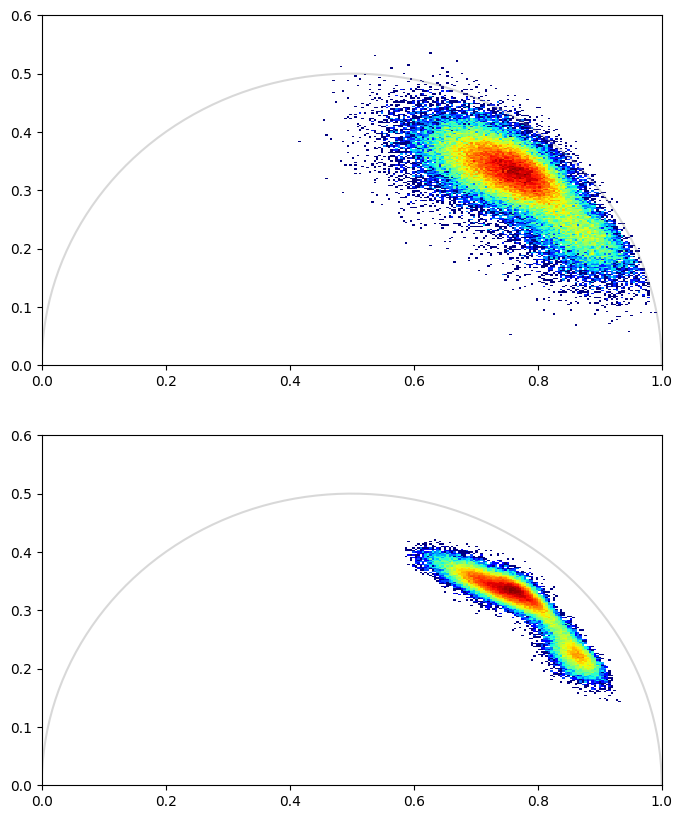

In [19]:
fig, ax = plt.subplots(2, 1, figsize=(8, 2*5))
g, s, dc = og_phasor_comp
g_b, s_b, dc_b = binned_phasor_comp

#phasor_plt.add_phasor_circle(current_axis)
add_phasor_circle(ax[0])
add_phasor_circle(ax[1])
output = ax[0].hist2d(x=np.ravel(g[space_mask]),y=np.ravel(s[space_mask]),bins=256,cmap='jet',norm='log',range=[[0, 1], [0, 0.6]])
output = ax[1].hist2d(x=np.ravel(g_b[space_mask]),y=np.ravel(s_b[space_mask]),bins=256,cmap='jet',norm='log',range=[[0, 1], [0, 0.6]])

#phasor_plt.add_2d_histogram(ax, np.ravel(g), np.ravel(s), bins=256, norm='log', range=[[0, 1], [0, 0.6]], cmap = 'jet')
